In [ ]:
pip install -U scikit-learn

In [1]:
# Load libraries and newsgroup data available fro sklearn
import sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
# categories = ['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']
newsgroups_train = fetch_20newsgroups(subset='train') #, categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test') #, categories=categories)
# class_names = ['christian','hockey','mideast','motorcycles']


In [ ]:
#The data is in the form of a dictionary
newsgroups_train.keys()

In [4]:
# The 20 classes in the data

newsgroups_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
# Converting data to pandas dataframes. Target is an integer mapping of the class names in target_names

def get_data(mydata):
    mydata.keys()
    df = pd.DataFrame([mydata['data'],[mydata['target_names'][idx] for idx in mydata['target']],mydata['target']])
    df = df.transpose()
    df.columns = ['content', 'target_names', 'target']
    return df
    
df = get_data(newsgroups_train)
df_test = get_data(newsgroups_test)

In [6]:
# There are 11314 messages in the training data and 7532 in the test data
df.shape,df_test.shape

((11314, 3), (7532, 3))

In [7]:
df.head()

,content,target_names,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space,14


In [8]:
# data cleaning

import re
from pprint import pprint
import nltk, spacy, gensim
from sklearn.feature_extraction.text import CountVectorizer

def get_lemmatized_clean_data(df):
    # Convert to list
    data = df.content.values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

#     pprint(data[:1])

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))

#     print(data_words[:1])
    
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        return texts_out

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # Run in terminal: python3 -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    # Do lemmatization keeping only Noun, Adj, Verb, Adverb
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_lemmatized

In [9]:
data_lemmatized = get_lemmatized_clean_data(df)
test_data_lemmatized = get_lemmatized_clean_data(df_test)

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']
[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'e

In [11]:
data_lemmatized

['where s thing subject car be nntp post host rac wam umd organization university maryland college park line be wonder out there enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know tellme model name engine spec year production where car be make history info have funky look car mail thank bring neighborhood lerxst',
 'guy kuo subject si clock poll final call summary final call si clock report keyword acceleration clock upgrade article shelley qvfo innc organization university washington line nntp post host carson edu fair number brave soul upgrade si clock oscillator have share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy be especially request be summarize next day so add network knowledge base have do clock upgrade have answer poll thank guy kuo',
 'thoma willi 

# Now lets Vectorize the data

In [12]:
# Converting training data texts to vectors contianing counts of words in the vocabulary
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [13]:
# data is represented as a sparse matrix only 854165 cells are non zero out of 11314*9745. 9745 is the vocabulary size after using the 
# filter min_df > 10 and number of characters > 3 
data_vectorized

<11314x9745 sparse matrix of type '<class 'numpy.int64'>'
	with 854165 stored elements in Compressed Sparse Row format>

In [14]:
# Use the Count Vector to build a model using Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(data_vectorized, df.target_names)
# predict label for one instance
print(clf.predict(data_vectorized[1]),df.target_names[1])

['comp.sys.mac.hardware'] comp.sys.mac.hardware


In [15]:
# Alternative Vectorizer: Binary Vector Representation of text

binary_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             binary=True #Returns a Binary Vector
                             # max_features=50000,             # max number of uniq words
                            )

binary_data_vectorized = binary_vectorizer.fit_transform(data_lemmatized)

In [16]:
# To see that the binary vector and count vectorizer are indeed different, summing the vectors for the same document
print(np.sum(binary_data_vectorized[1]),np.sum(data_vectorized[1])) 

56 72


In [17]:
#Target distribution for target in test data

(unique, counts) = np.unique(df_test['target_names'], return_counts=True)
(unique, counts)

(array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
        'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
        'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
        'sci.electronics', 'sci.med', 'sci.space',
        'soc.religion.christian', 'talk.politics.guns',
        'talk.politics.mideast', 'talk.politics.misc',
        'talk.religion.misc'], dtype=object),
 array([319, 389, 394, 392, 385, 395, 390, 396, 398, 397, 399, 396, 393,
        396, 394, 398, 364, 376, 310, 251], dtype=int64))

In [18]:
# Use the Binary Vector to build a model using Multivariate Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(binary_data_vectorized, df.target_names)
print(clf.predict(binary_data_vectorized[1]))

['comp.sys.mac.hardware']


In [19]:
predictions = clf.predict(binary_vectorizer.transform(test_data_lemmatized))

In [20]:
#Building out the Confusion Matrix
pd.crosstab(predictions,df_test['target_names'])

target_names,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
row_0,,,,,,,,,,,,,,,,,,,,
alt.atheism,202,2,1,0,0,0,0,0,0,3,0,2,0,10,2,5,0,26,4,42
comp.graphics,3,238,19,4,5,44,1,2,2,2,0,19,7,15,23,3,2,5,4,3
comp.os.ms-windows.misc,12,54,284,39,20,77,4,10,6,9,6,29,26,35,14,18,5,8,8,10
comp.sys.ibm.pc.hardware,5,11,33,273,20,9,18,3,1,0,0,7,38,3,1,4,3,5,4,10
comp.sys.mac.hardware,6,17,11,28,296,8,10,12,2,0,2,22,21,24,6,9,6,9,9,6
comp.windows.x,0,19,12,3,1,232,1,0,1,0,0,3,0,0,1,2,0,0,0,2
misc.forsale,15,29,13,19,26,21,342,48,18,32,20,18,44,51,39,31,30,24,14,15
rec.autos,2,0,2,1,3,0,3,292,6,0,0,2,6,3,6,0,10,2,7,5
rec.motorcycles,12,1,1,0,0,0,4,14,358,0,2,5,5,12,2,1,8,6,9,5


# Sematic Vectorization

In [21]:
size = data_vectorized.shape[0]*data_vectorized.shape[1]
print("Sparsicity: ", len(data_vectorized.data)/size*100, "%")

Sparsicity:  0.774718191739816 %


In [74]:
# Number of components chosen to explain 80% of variance in the original data (see plot below)
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=180)
lsa = svd.fit_transform(data_vectorized.T)

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
#Percentage of variance explained
np.sum(svd.explained_variance_ratio_)

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.800701701630763

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


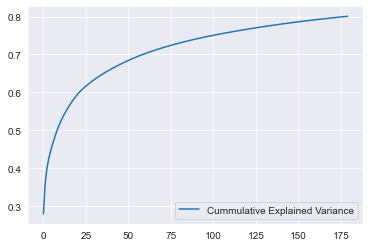

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

cdf = np.cumsum(svd.explained_variance_ratio_)
plt.plot(cdf, label="Cummulative Explained Variance")
plt.legend(loc='lower right')

# Using Topic Models (Latent Dirichlet Allocation)

In [24]:
from sklearn.decomposition import LatentDirichletAllocation
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=50,
                          n_components=20, n_jobs=-1, random_state=100)


In [25]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -9925284.360159846
Perplexity:  2019.802201780625
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [26]:
# Hyper Parameter Tuning for the LDA model

## Warning: This will take a number of hours to run, consider reducing the num values in n_topics and n_iter as 
## well as the number of iterations in n_iter before you run it

n_topics = [10, 15, 20] #, 15, 20, 25, 30
n_ldecay = [.5, .7, .9]
n_iter = [100,400] #10, 100, 200, 300,
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': n_topics, 'max_iter':n_iter} # 'learning_decay': n_ldecay, 

# Init the Model
lda = LatentDirichletAllocation(learning_decay = 0.7,learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online'),
             param_grid={'max_iter': [100, 400], 'n_components': [10, 15, 20]})

In [27]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'max_iter': 400, 'n_components': 10}
Best Log Likelihood Score:  -2078948.376945986
Model Perplexity:  2096.442624517237


In [28]:
best_lda_model.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 400,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

In [29]:
# Access performance for different parameter values in the grid search
result_keys=["split{}_test_score".format(idx) for idx in range(model.n_splits_)]

In [30]:
model.cv_results_

{'mean_fit_time': array([ 257.75059338,  287.68900385,  298.46345305,  935.64945521,
        1040.89633622, 1067.93133664]),
 'std_fit_time': array([ 6.21566743, 12.24163885, 11.59023265, 25.89054582, 58.00353834,
        56.99598879]),
 'mean_score_time': array([0.6591435 , 0.68042369, 0.70392923, 0.62214289, 0.63826838,
        0.62677355]),
 'std_score_time': array([0.02637588, 0.0436238 , 0.03487861, 0.04100163, 0.03237028,
        0.01262425]),
 'param_max_iter': masked_array(data=[100, 100, 100, 400, 400, 400],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_components': masked_array(data=[10, 15, 20, 10, 15, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_iter': 100, 'n_components': 10},
  {'max_iter': 100, 'n_components': 15},
  {'max_iter': 100, 'n_components': 20},
  {'max_iter': 400, 'n_components': 10},
  {'ma

In [31]:
# A way to look at the metrics from the perspective of a single hyper parameter, max_iter in the example below
# For 100 and 400 max_iters, we print the log likelihood for each of the values of n_components

def getmetrics(hyper_param,topic_model_output):
    results = []
    for val in search_params[hyper_param]: #'n_components': [10, 15, 20, 25, 30], learning_decay: [.5, .7, .9]}
        indexes = [gscore[hyper_param]==val for gscore in topic_model_output['params']]
        current=[]
        for key in result_keys:
            current.append((topic_model_output[key])[indexes])
        results.append(np.average(current,axis=0))
    return np.array(results)

results = getmetrics('max_iter',model.cv_results_)
results

array([[-2084118.75249209, -2090308.09450935, -2094303.95681718],
       [-2078948.37694599, -2087425.98213663, -2095842.54990618]])

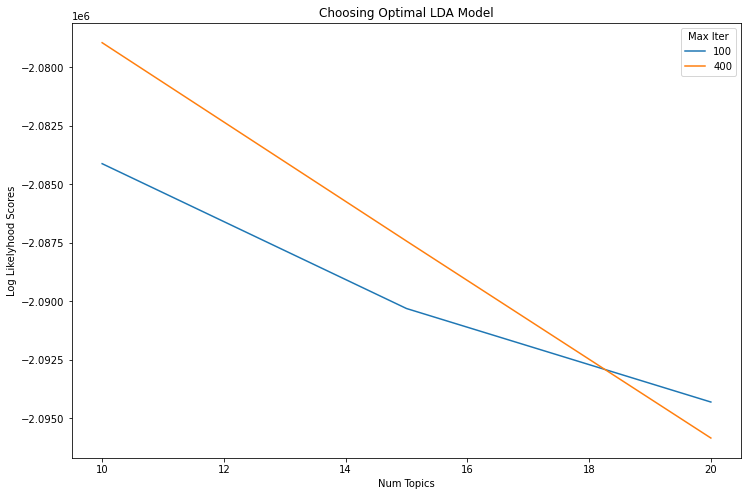

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show graph
plt.figure(figsize=(12, 8))
for ind in range(len(n_iter)):
    plt.plot(n_topics, results[ind], label=n_iter[ind])
# plt.plot(n_topics, results[1], label=n_iters[1])
# plt.plot(n_topics, results[2], label=n_iters[2])
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Max Iter', loc='best')
plt.show()

In [33]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.230000,0.000000,0.040000,0.580000,0.030000,0.000000,0.000000,0.000000,0.110000,4
Doc1,0.000000,0.890000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,1
Doc2,0.030000,0.570000,0.000000,0.030000,0.200000,0.000000,0.090000,0.060000,0.000000,0.020000,1
Doc3,0.000000,0.500000,0.000000,0.100000,0.230000,0.000000,0.000000,0.000000,0.000000,0.160000,1
Doc4,0.000000,0.000000,0.000000,0.180000,0.370000,0.000000,0.000000,0.310000,0.130000,0.000000,4
Doc5,0.110000,0.000000,0.000000,0.000000,0.290000,0.280000,0.140000,0.150000,0.030000,0.000000,4
Doc6,0.000000,0.410000,0.000000,0.080000,0.180000,0.320000,0.000000,0.000000,0.000000,0.000000,1
Doc7,0.000000,0.530000,0.000000,0.390000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1
Doc8,0.000000,0.370000,0.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.060000,0.130000,3
Doc9,0.000000,0.450000,0.000000,0.230000,0.310000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [34]:
# Show top n keywords for each topic
def show_topics(lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(list(zip(keywords.take(top_keyword_locs),topic_weights.take(top_keyword_locs))))
    return topic_keywords

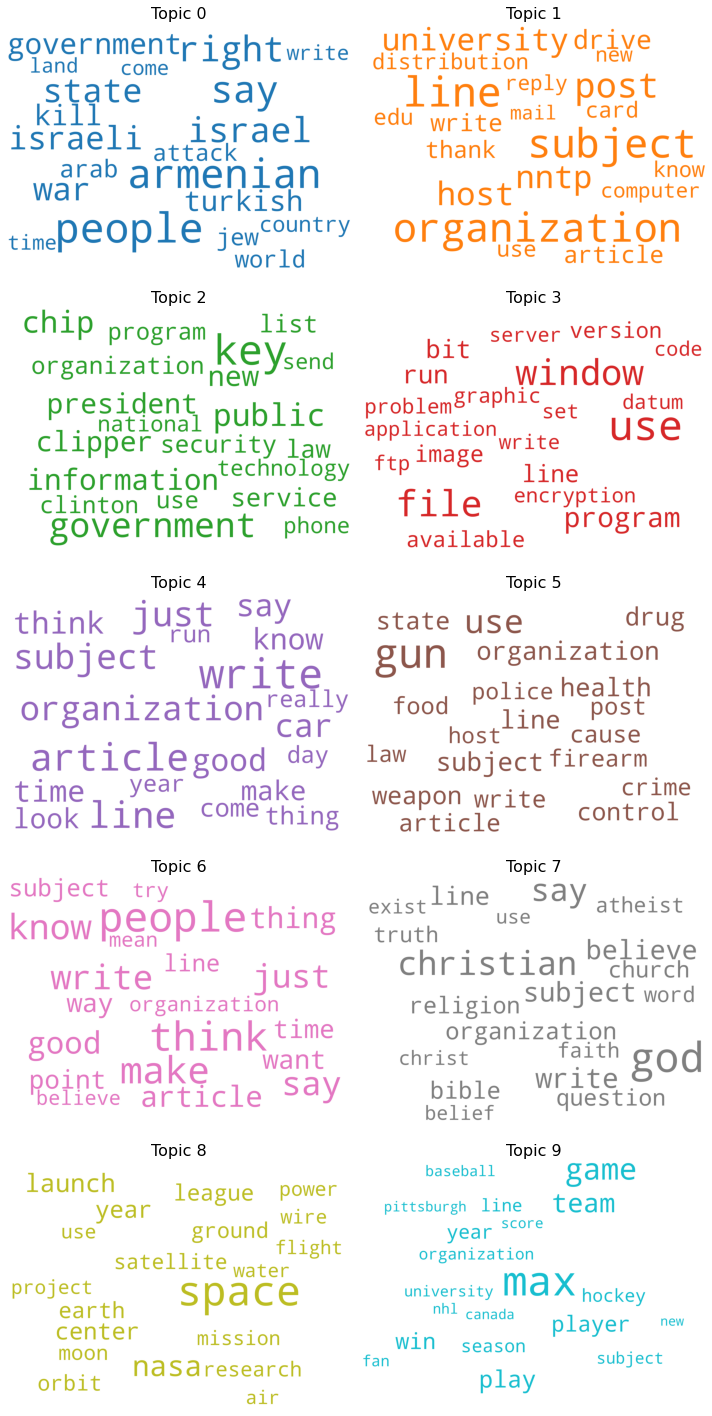

In [35]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = show_topics(best_lda_model)

fig, axes = plt.subplots(5, 2, figsize=(10,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [36]:
# Words distribution in each topic. The number in brackets is the expected frequency of the word in a corpus generated by the model of the size 
# of the training data
topic_keywords = show_topics(lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,"(people, 1381.6355068435294)","(armenian, 1327.00892392236)","(say, 1155.5119940769775)","(right, 1006.2206073742339)","(israel, 960.9761106148986)","(state, 895.1725127644332)","(israeli, 837.3186058487235)","(war, 828.6778514846359)","(government, 786.83458153353)","(turkish, 749.0916858246712)","(kill, 741.1580020935047)","(arab, 538.7364038982093)","(jew, 499.4348496268598)","(world, 498.3272068135214)","(attack, 490.60202573532723)"
Topic 1,"(line, 5638.222144522965)","(subject, 5387.283158954223)","(organization, 5362.505801415183)","(post, 4012.7106849211536)","(host, 3393.0311947813966)","(nntp, 3341.358179301458)","(university, 3141.219645628888)","(drive, 2168.120695042948)","(write, 1807.4213458898046)","(article, 1788.0353914934717)","(thank, 1746.2808798846236)","(use, 1545.2460279748666)","(edu, 1544.1477817782118)","(card, 1527.0416333775622)","(distribution, 1484.5987799894478)"
Topic 2,"(key, 1756.4328691301157)","(government, 1181.08119582723)","(public, 959.5339183159859)","(chip, 901.5593167606577)","(information, 835.8456789351962)","(new, 788.110442029045)","(clipper, 773.2275405492107)","(president, 765.7283890158755)","(service, 626.5871731337451)","(law, 601.9403696858592)","(list, 583.6742145898534)","(security, 578.9168591981439)","(organization, 567.543099719253)","(use, 555.0108026914905)","(clinton, 547.1460442495338)"
Topic 3,"(use, 4035.390680843246)","(file, 3005.621235492062)","(window, 2913.708968724691)","(program, 1616.44073254975)","(run, 1353.2766695647445)","(bit, 1330.2538830233032)","(line, 1197.748316225939)","(image, 1110.6222022471734)","(available, 1003.7360739378164)","(version, 1001.1053922975631)","(graphic, 899.712304563477)","(problem, 887.5178915179683)","(set, 876.0051486349339)","(encryption, 862.4928478510959)","(datum, 845.7517007221593)"
Topic 4,"(write, 2932.931898121538)","(article, 2438.4245013684886)","(line, 2271.9135659815697)","(just, 2070.093524301304)","(subject, 2031.757940214501)","(organization, 1953.9646881058636)","(car, 1784.9578330908787)","(say, 1644.086281745233)","(good, 1643.1846532378365)","(think, 1554.6032843621867)","(time, 1509.8396021301762)","(know, 1466.9596508391455)","(look, 1273.670148369847)","(make, 1231.670808305149)","(come, 1063.4539875114267)"
Topic 5,"(gun, 1705.4243623567047)","(use, 1020.9122954205864)","(subject, 568.6598061734102)","(health, 556.7757702718162)","(organization, 555.1386329940667)","(line, 549.2073434374946)","(drug, 542.0512412706274)","(weapon, 529.6048225140141)","(state, 521.0163536230558)","(control, 508.9986014213564)","(article, 498.88892349805565)","(write, 494.9821669340541)","(cause, 485.22298661029606)","(crime, 476.1176555194198)","(food, 473.432837787548)"
Topic 6,"(people, 3372.8839343197037)","(think, 3122.8542227494486)","(make, 2755.9355180276702)","(know, 2387.7806251045204)","(write, 2277.1703859681184)","(say, 2196.5394688176348)","(just, 2078.712081395836)","(good, 1842.8839912322317)","(article, 1650.893506625404)","(thing, 1631.055833034812)","(want, 1338.5570106585512)","(way, 1292.2000648178434)","(point, 1263.2518555369472)","(time, 1243.6660376655086)","(subject, 1102.5308192967027)"
Topic 7,"(god, 2631.943753637658)","(christian, 1615.826774960901)","(say, 1453.2687186619992)","(write, 1086.7854056127326)","(subject, 1035.7315329437004)","(believe, 1019.7576619389156)","(line, 899.9378555049478)","(organization, 796.9187715857023)","(bible, 789.7045623134916)","(religion, 763.0125904789107)","(question, 744.4328601054102)","(church, 730.3783709117686)","(truth, 665.7748290295996)","(word, 640.4923283347476)","(atheist, 630.0065006272378)"
Topic 8,"(space, 1739.5287329033667)","(nasa, 711.9242354941556)","(launch, 523.8466922793085)","(year, 471.336877122931)","(center, 458.74761273090525)","(league, 410.1374631717137)","(earth, 406.7257157744847)","(orbit, 377.320930399

In [37]:
import pyLDAvis
from pyLDAvis import sklearn 
pyLDAvis.enable_notebook()
panel = sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  14.983320
1       0.648955  71.707100       2        1  14.720389
4      71.019684   9.971006       3        1  13.262359
3       3.785981  33.185135       4        1  13.254656
2     -42.666500  -9.222070       5        1   9.093370
7      -3.621689 -43.526516       6        1   8.537124
0      -3.632402  -4.171708       7        1   8.461135
5     -36.584400  35.804413       8        1   6.913910
9      44.391380  50.615383       9        1   5.561250
8      40.235809 -31.591665      10        1   5.212487, topic_info=              Term         Freq         Total Category  logprob  loglift
5352           max  4284.000000   4284.000000  Default  30.0000  30.0000
3674           god  2608.000000   2608.000000  Default  29.0000  29.0000
3540          game  1989.000000   1989.000000  Default  28.0000  28.0000
3282          file  3097.000000   3097.000000  Default  27.0000  27.0000
9563        window  3053.000000   3053.000000  Default  26.0000  26.0000
...            ...          ...           ...      ...      ...      ...
9219           use   311.922064   8975.374101  Topic10  -5.3842  -0.4054
6854       program   267.581760   2419.177599  Topic10  -5.5375   0.7524
7683       science   247.933920   1578.994690  Topic10  -5.6138   1.1027
6183  organization   245.997701  11308.601000  Topic10  -5.6216  -0.8739
5054          line   245.990095  13064.967324  Topic10  -5.6216  -1.0183

[711 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
12        1  0.995786  abortion
20        6  0.996035  absolute
44        1  0.018967    access
44        2  0.315547    access
44        3  0.019829    access
...     ...       ...       ...
9702      7  0.095772      year
9702      8  0.099563      year
9702      9  0.199378      year
9702     10  0.118515      year
9704      8  0.987567     yeast

[1647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 4, 3, 8, 1, 6, 10, 9])

In [38]:
# Data used to generate the visualization above, x,y coordinates of the topic centroids and the radius (Freq)

panel.to_dict()["mdsDat"]

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'x': [32.42095184326172,
  0.648955225944519,
  71.01968383789062,
  3.7859814167022705,
  -42.666500091552734,
  -3.6216893196105957,
  -3.632401704788208,
  -36.58440017700195,
  44.391380310058594,
  40.235809326171875],
 'y': [8.115229606628418,
  71.70709991455078,
  9.971006393432617,
  33.18513488769531,
  -9.22206974029541,
  -43.52651596069336,
  -4.171707630157471,
  35.804412841796875,
  50.61538314819336,
  -31.591665267944336],
 'topics': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'cluster': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Freq': [14.983320244442574,
  14.72038905615653,
  13.262358747969575,
  13.254656465925455,
  9.093369850824502,
  8.5371243444054,
  8.461134955100883,
  6.913909995125353,
  5.561249559203381,
  5.212486780846365]}

In [68]:
# This is how the data is generated. Each topic is a categorical distribution across the entire vocabulary so the distance between two topics
# can be measured as the kullback-Liebler divergence between the distributions. As KL-divergance is not a symmetric metric, we tahe the average of KL(p,q) 
# and KL(q,p). This is referred to as the jensen shannon distance
# Here we calculate the distance matrix.

tops = best_lda_model.components_ #best_lda_model.get_topics() kullback-Leibler divergence (KL(1,b)+KL(b,a))/2
from scipy.spatial import distance
dists=[]
for i in range(tops.shape[0]):
    dists.append(distance.jensenshannon(tops.T,tops[i].reshape(1,tops.shape[1]).T))
dists = np.vstack(dists)

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
docs[1]

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.00137029, 0.88871987, 0.00137018, 0.03595578, 0.0013704 ,
       0.00137027, 0.00137032, 0.00137019, 0.00137028, 0.06573243])

In [94]:
cnts

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


matrix([[110342.76089701],
        [191970.50733191],
        [118587.81836268],
        [172855.69807747],
        [172956.14453891],
        [ 90165.19905473],
        [195399.42713941],
        [111333.74840156],
        [ 67976.7177323 ],
        [ 72524.97846401]])

In [95]:
# Using any dimensionality reduction method like MDS or tSNE we can now map thess point onto a two or more dimensional space. 
# Here we use 2 dimensions and tSNE.

from sklearn.manifold import MDS,TSNE
import math
# mds_model = MDS(n_components=2,dissimilarity='precomputed')
mds_model = TSNE(n_components=2, random_state=0, metric='precomputed')
coords = mds_model.fit_transform(dists)

# Here we calulcate the Radius
vecs=lda_output #lda.lda_model[lda.corpus]
finvec=[]
for vec in vecs:
    finvec.append([y for y in vec])
docs = np.array(finvec)
# totals = np.sqrt(np.sum(docs,axis=0)/(docs.shape[0]*math.pi))
# totals
doc_lengths=np.sum(data_vectorized,axis=1) #Number of words in a docuument
cnts = docs.T*doc_lengths #aportion length of each document by topic. docs is the topic vector for the document. So if there are two topics with 
# probabilities 0.3 and 0.7 for a document and the document has a length of 80 words,cnts now contains the values [24,56] for the document and 
# sum all words assigned to a topic. So cnts is a 10 element array with the expected number of words generated by each topic 
totals = cnts/np.sum(cnts)*100 # The radius is the percentage of words generated by each topic
totals, sum(totals)

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(matrix([[ 8.46113496],
         [14.72038906],
         [ 9.09336985],
         [13.25465647],
         [13.26235875],
         [ 6.91391   ],
         [14.98332024],
         [ 8.53712434],
         [ 5.21248678],
         [ 5.56124956]]),
 matrix([[100.]]))

In [71]:
coords

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 32.42095  ,   8.11523  ],
       [  0.6489552,  71.7071   ],
       [ 71.019684 ,   9.971006 ],
       [  3.7859814,  33.185135 ],
       [-42.6665   ,  -9.22207  ],
       [ -3.6216893, -43.526516 ],
       [ -3.6324017,  -4.1717076],
       [-36.5844   ,  35.804413 ],
       [ 44.39138  ,  50.615383 ],
       [ 40.23581  , -31.591665 ]], dtype=float32)

C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


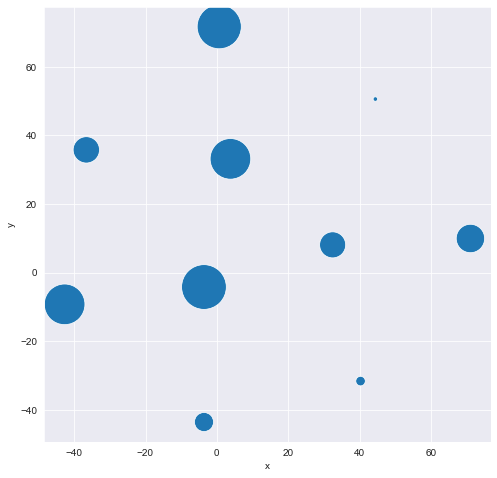

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# Control figure size for this notebook:
plt.rcParams['figure.figsize'] = [8, 8]

# data 
data = pd.DataFrame(np.concatenate([coords,totals.reshape(len(totals),1)],axis=1),columns=['x','y','radius'])
 
# use the scatterplot function to build the bubble map
sns.scatterplot(data=data, x="x", y="y", size="radius", legend=False, sizes=(20, 2000))

# show the graph
plt.show()

In [47]:
# The top words associated with each topic
keywords = np.array(vectorizer.get_feature_names())
for i in range(best_lda_model.components_.shape[0]):
    x=np.argsort(best_lda_model.components_[i])[::-1][0:5]
    print(x,[keywords[w] for w in x])

[6443 7650  481 4783 9022] ['people', 'say', 'armenian', 'kill', 'turkish']
[3674 7650 9651 8766 6443] ['god', 'say', 'write', 'think', 'people']
[1274 8143 9219 8819 9651] ['car', 'space', 'use', 'time', 'write']
[5352 3380  721 3692 2541] ['max', 'food', 'bank', 'gordon', 'disease']
[4770 9219 4354 1457 2887] ['key', 'use', 'information', 'chip', 'encryption']
[3540 8642 9702 6598 9560] ['game', 'team', 'year', 'play', 'win']
[9563 9219 3282 6854 7560] ['window', 'use', 'file', 'program', 'run']
[6443 3797 8281 5240 7650] ['people', 'gun', 'state', 'make', 'say']
[5054 8405 6183 6686 4082] ['line', 'subject', 'organization', 'post', 'host']
[9651 4585 4586  504 5054] ['write', 'israel', 'israeli', 'article', 'line']


C:\Users\91858\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
